# Standart importlar ve veriye ilk bakış

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# tekrarlanan rowlar var mı ?
data.duplicated().sum()

0

In [3]:
# boş veriler var mı ?
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
print(f"Toplam veri sayısı: {len(data)}")

Toplam veri sayısı: 768


In [6]:
# labellarda aşırı dengesizlik(imbalance) var mı ?
data["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

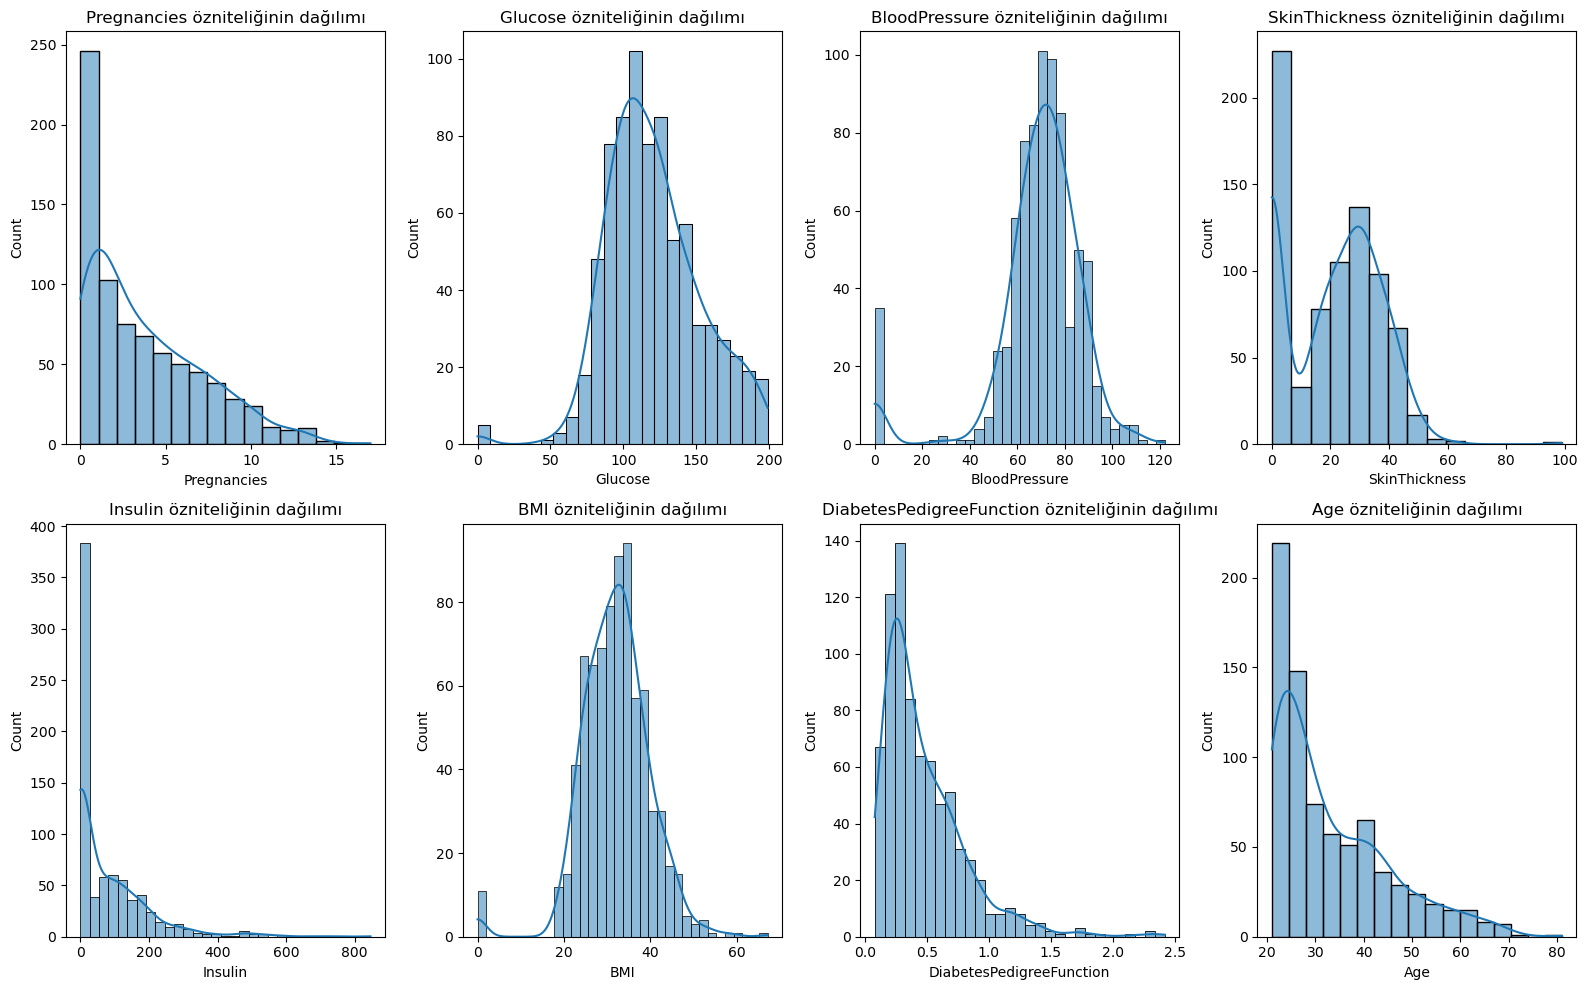

In [7]:
cols_to_plot = data.columns[:-1]

plt.figure(figsize=(16, 10))

for i, column in enumerate(cols_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f"{column} özniteliğinin dağılımı")
    
plt.tight_layout();

## Yorum :

Bazı özniteliklerde garip dağılımlar var. Glucose, BloodPressure, SkinThickness, BMI, Insulin özniteliklerinde 0 değerinde bir yığılma var. Büyük ihtimalle bu verilerin eksik olduğu yerlerde(veri alınan kişiden bu verileri alamadıklarında) bu öznitelikler 0'a eşitlenmiş. Bu olay dışında öznitelikler beklenildiği gibi normal dağılıma yaklaşık bir dağılım sergiliyor

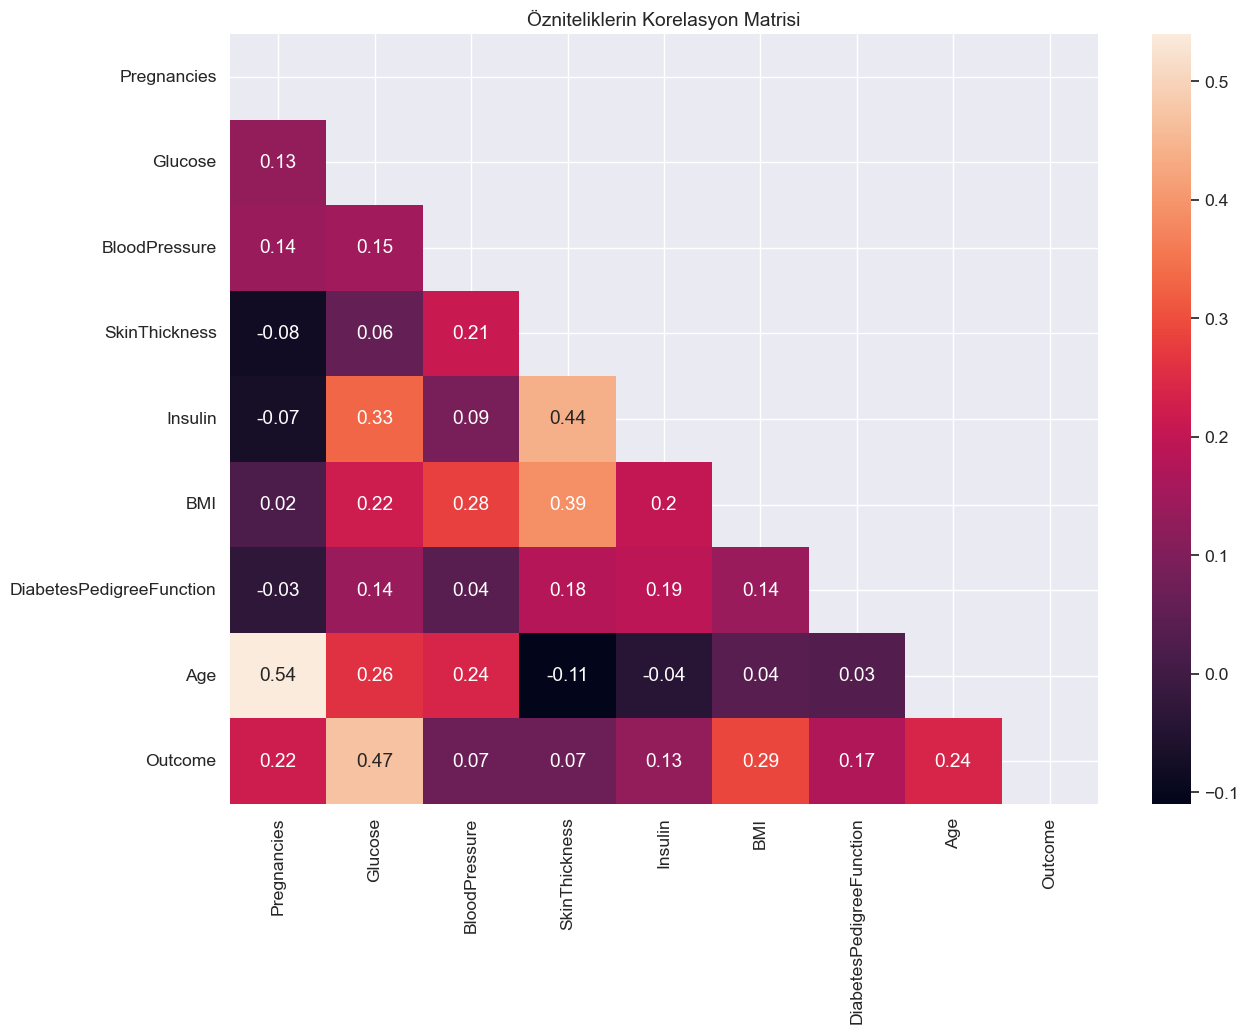

In [8]:
# Özniteliklerin kendi arasındaki korelasyonuna korelasyon matrisi ile bakalım

corr = data.corr().round(2)

plt.figure(figsize=(14, 10))
sns.set(font_scale=1.15)
# bu mask üst üçgeni kaldıracak (çünkü alt üçgenin simetriği)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot = True,mask = mask, cbar = True)
plt.title('Özniteliklerin Korelasyon Matrisi');

## Yorum :

Birbirleri arasında yüksek korelasyona sahip özniteliklerin birtanesinin kaldırılması bazen iyi bir fikir olabilir ancak bu veri setinde yüksek korelasyona sahip özniteliklerle karşılaşmıyoruz bu demektirki her bir öznitelik modelimize "farklı bir bilgi" verebilir.

# Baseline Modelleme (En "zayıf" model)

In [9]:
# sık kullanılan değerleri burdan değiştirmek için
class CFG:
    test_size = 0.3
    random_state = 101

In [10]:
# tüm veriler nümerik olduğu için tek bir preprocess adımından geçirip logistic regresyona sokabiliriz 
# ama önce veriyi train ve test diye ayıralım

from sklearn.model_selection import train_test_split

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CFG.test_size, random_state=CFG.random_state)

print(f"Train verisinin büyüklüğü: {len(X_train)}")
print(f"Test verisinin büyüklüğü: {len(X_test)}")

Train verisinin büyüklüğü: 537
Test verisinin büyüklüğü: 231


In [11]:
# unit testler
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [12]:
# from sklearn.preprocessing import StandardScaler
# Preprocessing için RobustScaler veya MinMaxScaler de kullanılabilir ancak şuanlık bir şey kullanmayalım çünkü
# bazı verilerimiz sıfıra eşitlenmiş durumda

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([('logreg', LogisticRegression(max_iter=1000))])
# processing ile beraber yapmak isteseydik : pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
pipe.fit(X_train, y_train);

In [13]:
# modelin bazı metriklerini inceleyelim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.7835497835497836

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       150
           1       0.73      0.60      0.66        81

    accuracy                           0.78       231
   macro avg       0.77      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231



In [16]:
print(confusion_matrix(y_test, y_pred))

[[132  18]
 [ 32  49]]


# Feature Engineering (Öznitelik Mühendisliği)

Gariplik bulduğumuz özniteliklere geri dönelim ve bulunamayan değerleri 0'a eşitlemek yerine farklı stratejiler deneyelim

In [17]:
cols_to_change = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [18]:
# 0 olan verileri np.nan yapalım
data[cols_to_change] = data[cols_to_change].replace(0, np.nan)

In [19]:
data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Bu doldurulmayan verileri doldurmak için 3 farklı yöntem deneyeceğiz.\
Deneyeceğimiz yöntemler : diğer verilerin ortalaması ile bu verileri doldurmak, medyan ile doldurmak, doldurmak için knn kullanmak. Ve bunları güvenli bir şekilde cross-validation(cv) yaparak karşılaştıracağız

In [20]:
# öncelikle tekrardan veriyi train ve test diye ayıralım
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CFG.test_size, random_state=CFG.random_state)

In [21]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [22]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score

mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
knn_imputer5 = KNNImputer(n_neighbors=5)
knn_imputer7 = KNNImputer(n_neighbors=7)
knn_imputer9 = KNNImputer(n_neighbors=9)

X_train_mean_imputed = mean_imputer.fit_transform(X_train)
X_train_median_imputed = median_imputer.fit_transform(X_train)
X_train_knn5_imputed = knn_imputer5.fit_transform(X_train)
X_train_knn7_imputed = knn_imputer7.fit_transform(X_train)
X_train_knn9_imputed = knn_imputer9.fit_transform(X_train)

model = LogisticRegression(max_iter=1000)

imputation_methods = {
    'Mean Imputation': X_train_mean_imputed,
    'Median Imputation': X_train_median_imputed,
    'KNN(5 neighbors) Imputation': X_train_knn5_imputed,
    'KNN(7 neighbors) Imputation': X_train_knn7_imputed,
    'KNN(9 neighbors) Imputation': X_train_knn9_imputed,
}

for method, X_imputed in imputation_methods.items():
    scores = cross_val_score(model, X_imputed, y_train, cv=5, scoring='accuracy')
    print(f'{method}: Mean Accuracy = {scores.mean()}')

Mean Imputation: Mean Accuracy = 0.7654897888542747
Median Imputation: Mean Accuracy = 0.763637937002423
KNN(5 neighbors) Imputation: Mean Accuracy = 0.7598823122187607
KNN(7 neighbors) Imputation: Mean Accuracy = 0.7617341640706126
KNN(9 neighbors) Imputation: Mean Accuracy = 0.7579958463136034


In [23]:
# ortalama ile doldurmanın biraz daha iyi olduğunu görüyoruz 

data_mean = data[cols_to_change].mean()
data[cols_to_change] = data[cols_to_change].replace(np.nan, data_mean)

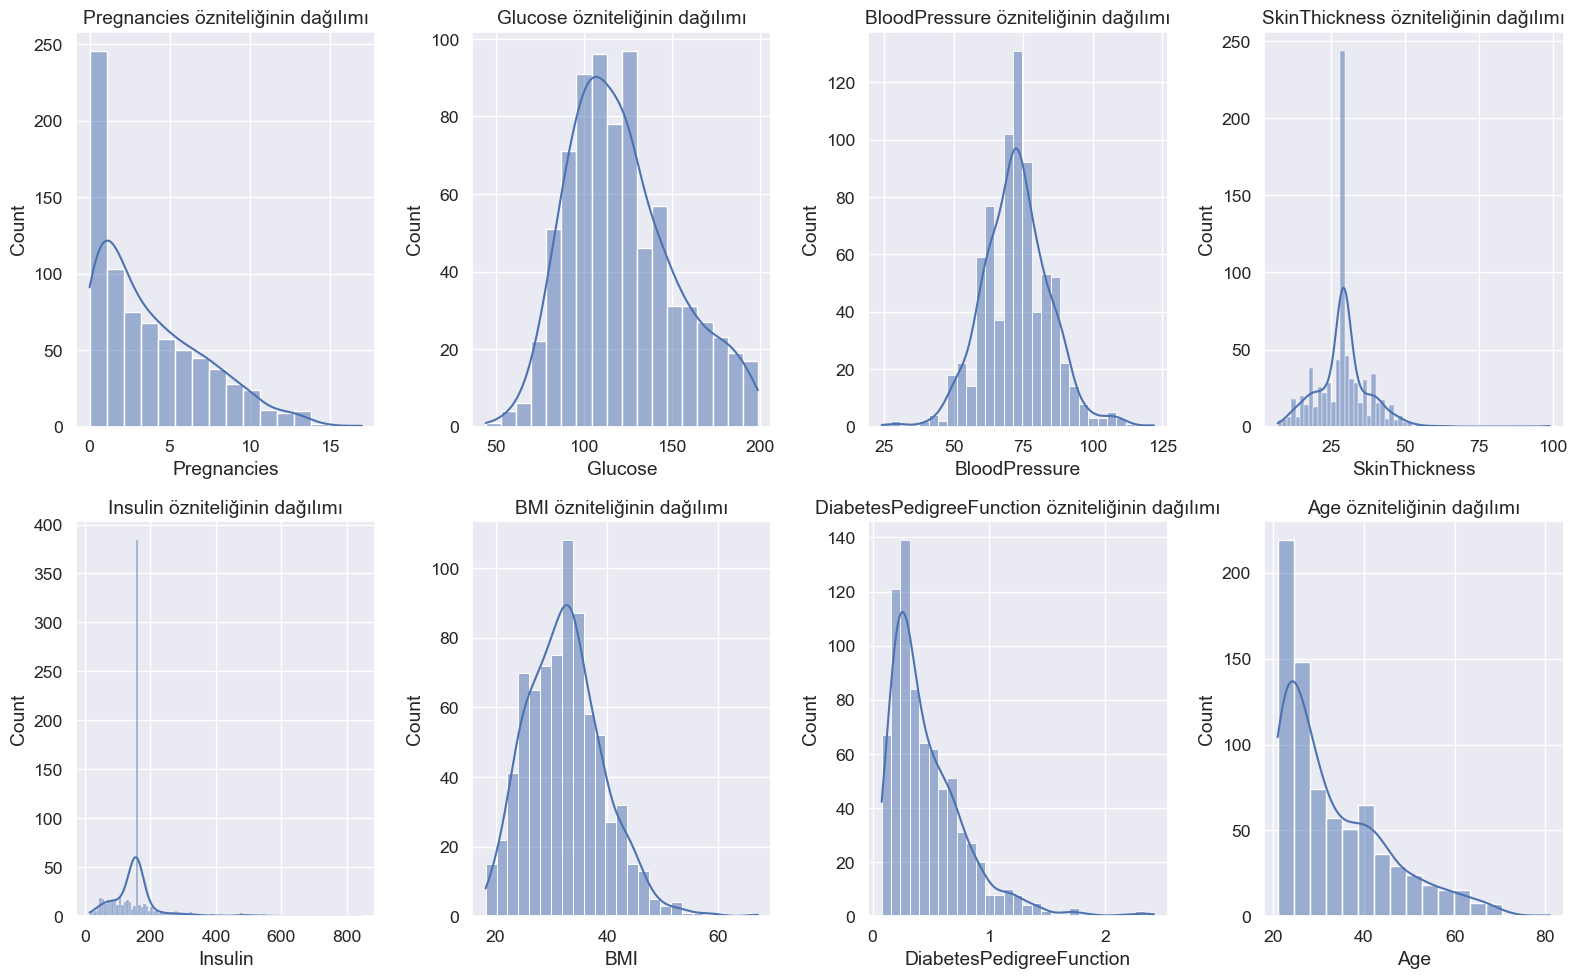

In [24]:
# tekrardan özniteliklerimizin şekillerine bakalım (özniteliklerin normal dağılıma daha yakın olmasını bekliyoruz)
cols_to_plot = data.columns[:-1]

plt.figure(figsize=(16, 10))

for i, column in enumerate(cols_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f"{column} özniteliğinin dağılımı")
    
plt.tight_layout();

## Yorum : 

Normal dağılıma daha fazla yaklaşsakta(bu iyi bir şey çünkü çoğu model normal dağılımla daha iyi çalışır) halan bazı özniteliklerin tek taraflı bir dağılıma sahip olduğunu görüyoruz. Bunu değiştirmek için QuantileTransform denilen yöntem ile verilerimizi normal dağılıma daha da yakınlaştıracağız(alternatif olarak box-cox transform da kullanılabilir).

## Dikkat : Bu yapacağımız dönüşüm linear bir dönüşüm değildir. Non-linear dır dolayısıyla verinin şekli değişecektir

In [25]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(n_quantiles=100, random_state=CFG.random_state, output_distribution='normal')

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_scaled = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=CFG.test_size, random_state=CFG.random_state)

In [27]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.7748917748917749

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       150
           1       0.70      0.63      0.66        81

    accuracy                           0.77       231
   macro avg       0.75      0.74      0.75       231
weighted avg       0.77      0.77      0.77       231



In [29]:
print(confusion_matrix(y_test, y_pred))

[[128  22]
 [ 30  51]]


In [30]:
# Model neredeyse aynı sonuçları verdi ancak sadece baseline modelimiz olan logistic regression üzerinde test ettiğimizi unutmayalım.
# Şimdi daha güçlü modeller bulalım ve bunları "ensemble" edip en güçlü modelimizi ortaya koyalım ve metriklerine bakalım.

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Bir sürü model!
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC())
]
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name}: Accuracy = {scores.mean()}, Standart Sapma = {scores.std()}')

Logistic Regression: Accuracy = 0.7654205607476635, Standart Sapma = 0.02867651587395562
Decision Tree: Accuracy = 0.6706126687435099, Standart Sapma = 0.06059552128217316
Random Forest: Accuracy = 0.7450155763239875, Standart Sapma = 0.04271259170194062
Gradient Boosting: Accuracy = 0.752509518864659, Standart Sapma = 0.05367210057557444
AdaBoost: Accuracy = 0.7188300449982692, Standart Sapma = 0.040076676492559145
KNN: Accuracy = 0.7319141571478021, Standart Sapma = 0.024451527486678965
SVM: Accuracy = 0.7467462789892696, Standart Sapma = 0.04697911332237703


In [31]:
# En iyi modellerimiz : 
# Logistic Regression, Gradient Boosting, KNN, SVC(linear) 
# Bunların önce önemli hiperparametlerini ayarlayalım sonrada değişik şekillerde ensemble ederek en iyi modeli bulalım.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Logistic Regression Tuning
logistic_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']}
grid_logistic = GridSearchCV(LogisticRegression(), param_grid=logistic_params, cv=5, scoring='accuracy')
grid_logistic.fit(X_train, y_train)
print(f"Logistic Regression için en iyi parametreler : {grid_logistic.best_params_}")
print(f"Logistic Regression için en iyi skor : {grid_logistic.best_score_}")

Logistic Regression için en iyi parametreler : {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression için en iyi skor : 0.7672724125995154


In [32]:
# Gradient Boosting Tuning
gb_params = {'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800], 
             'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.5, 1],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
            
random_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=gb_params, cv=5, n_iter=100, n_jobs=-1)
random_gb.fit(X_train, y_train)
print(f"Gradient Boosting Classifier için en iyi parametreler : {random_gb.best_params_}")
print(f"Gradient Boosting Classifier için en iyi skor : {random_gb.best_score_}")

Gradient Boosting Classifier için en iyi parametreler : {'subsample': 0.1, 'n_estimators': 400, 'learning_rate': 0.01}
Gradient Boosting Classifier için en iyi skor : 0.7655244029075805


In [33]:
# KNN Tuning
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, cv=5)
grid_knn.fit(X_train, y_train)
print(f"KNN için en iyi parametreler : {grid_knn.best_params_}")
print(f"KNN için en iyi skor : {grid_knn.best_score_}")

KNN için en iyi parametreler : {'n_neighbors': 7}
KNN için en iyi skor : 0.7374350986500519


In [34]:
# SVM Tuning
svm_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': ["scale", "auto"], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_svm = GridSearchCV(SVC(), param_grid=svm_params, cv=5)
grid_svm.fit(X_train, y_train)
print(f"SVM için en iyi parametreler : {grid_svm.best_params_}")
print(f"SVM için en iyi skor : {grid_svm.best_score_}")

SVM için en iyi parametreler : {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVM için en iyi skor : 0.7616649359640013


In [35]:
# Şimdi en iyi modelleri birleştirelim ve final sonuçlara bakalım
# VotingClassifier için bkz: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('Logistic Regression', grid_logistic.best_estimator_),
    ('Gradient Boosting', random_gb.best_estimator_),
    ('KNN', grid_knn.best_estimator_),
    ('SVM', SVC(**grid_svm.best_params_, probability=True))
], voting='hard')

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')

Ensemble Model Accuracy: 0.7965367965367965


Ayrıca VotingClassifier yerine 'stacking' methodunu kullanabiliriz. bkz : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

In [36]:
from sklearn.ensemble import StackingClassifier

meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[
        ('Logistic Regression', grid_logistic.best_estimator_),
        ('KNN', grid_knn.best_estimator_),
        ('Gradient Boosting', random_gb.best_estimator_),
        ('SVM', SVC(**grid_svm.best_params_, probability=True))
    ],
    final_estimator=meta_model,
    cv=5
)

stacking_model.fit(X_train, y_train)

stacking_accuracy = stacking_model.score(X_test, y_test)
print(f'Stacking Model Accuracy: {stacking_accuracy}')

Stacking Model Accuracy: 0.7792207792207793


In [37]:
# En iyi modelin son metrikleri

y_pred = ensemble_model.predict(X_test)

print(f"Accuracy score : {accuracy_score(y_test, y_pred)}")
print("---"*25)
print(classification_report(y_test, y_pred))
print("---"*25)
print(confusion_matrix(y_test, y_pred))

Accuracy score : 0.7965367965367965
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       150
           1       0.75      0.63      0.68        81

    accuracy                           0.80       231
   macro avg       0.78      0.76      0.77       231
weighted avg       0.79      0.80      0.79       231

---------------------------------------------------------------------------
[[133  17]
 [ 30  51]]


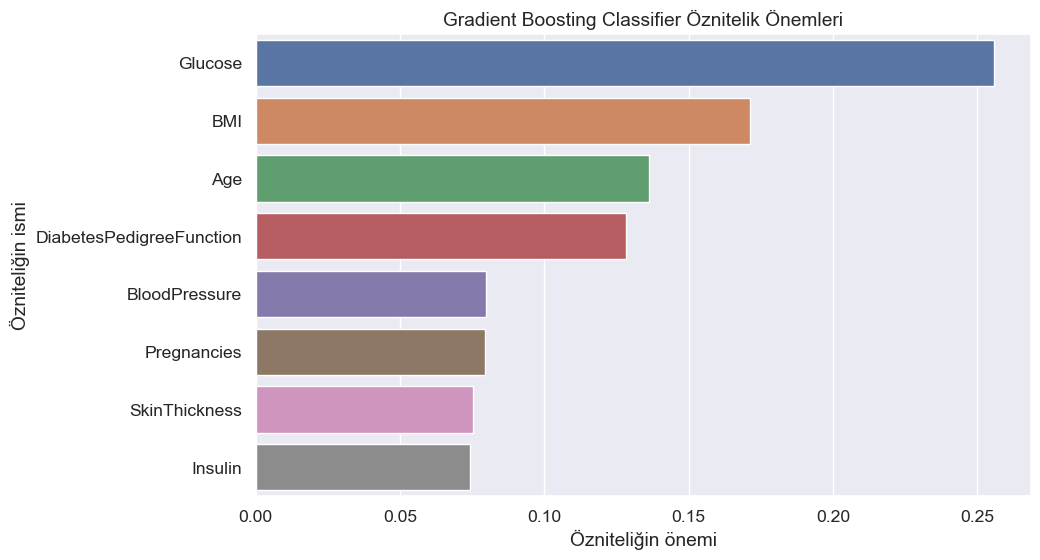

In [40]:
# Ayrıca tree modellerinin "feature importances" özelliği sayesinde 
# hangi özniteliklerin modelimize daha fazla katkıda bulunduğunu bulabiliriz

gb_classifier = random_gb.best_estimator_
gb_classifier.fit(X_train, y_train)

feature_importances = gb_classifier.feature_importances_
feature_names = list(data.columns[:-1])

feature_importances_df = pd.DataFrame({'Öznitelik': feature_names, 'Önemi': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Önemi', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances_df, x='Önemi', y='Öznitelik')
plt.xlabel('Özniteliğin önemi')
plt.ylabel('Özniteliğin ismi')
plt.title('Gradient Boosting Classifier Öznitelik Önemleri');